# 2. Machine learning models

Now, we will build ML models to predict conversion rates based on user profiles. Our goal is to make accurate predictions and gain insights on how to improve user conversions. 

We choose the following models: 
1. Logistic regression
2. Random forest

In [144]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import time
sns.set_theme()

Fontsize=12

## 2.1. Data preprocessing 

We create dummy variables for the categorical features (country and source)

In [17]:
df = pd.read_csv('conversion_data_clean.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [18]:
df_dummy = pd.get_dummies(df,drop_first=True)

In [24]:
df_dummy.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


Now we split the data into train and test sets.

In [27]:
X= df_dummy.drop(['converted'],axis=1)
Y = df_dummy['converted']

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of y_test is {y_test.shape}')


The shape of X_train is (221338, 8)
The shape of X_test is (94860, 8)
The shape of y_train is (221338,)
The shape of y_test is (94860,)


## 2.2. Logistic regression

In [45]:
from sklearn.linear_model import LogisticRegression

### 2.2.1. Hyperparameter tuning 
We determine the regularization method and penalty paremeter C for the logistic model using cross-validated grid search. To take data imbalance in consideration, we use the macro F1 score. 

The optimal parameters are found to be:
- regularization method = L2 
- penalty parameter C = 1000

In [194]:
penalty = ['l1','l2']
C = [0.001,0.01,0.1,1,10,100,1000]
t=time.time()
grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,scoring='f1_macro',return_train_score=True)
model.fit(X_train,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 95.06563186645508 seconds.


In [195]:
best_params_lr = model.best_params_
print(best_params_lr)

{'C': 1000, 'penalty': 'l2'}


In [196]:
train_f1 = model.cv_results_['mean_train_score'].reshape(len(penalty),len(C))
cv_f1 = model.cv_results_['mean_test_score'].reshape(len(penalty),len(C))

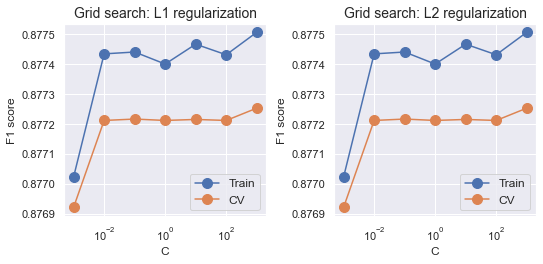

In [199]:
fig, axes = plt.subplots(1,2,figsize= (8,4))
plt.tight_layout(pad=3)
titles = [train_f1,cv_f1]
for i in range(len(penalty)):
    scores_train = train_f1[1]
    scores_cv = cv_f1[1]

    axes[i].semilogx(C,scores_train,'-o',markersize=10,label='Train')
    # axes[i].set_title('Grid search train: L1 regularization')
    axes[i].semilogx(C,scores_cv,'-o',markersize=10,label='CV')
    # axes[i].set_title('Grid search CV: L1 regularization')
    axes[i].legend(fontsize=Fontsize)
    axes[i].set_xlabel('C',fontsize=Fontsize)
    axes[i].set_ylabel('F1 score',fontsize=Fontsize)
    axes[i].set_title(f"Grid search: {'L1 regularization' if i==0 else 'L2 regularization'}",fontsize=Fontsize+2)
    # axes[i].set_xlabel("number of estimators")
    # axes[i].set_ylabel("maximum depth")
plt.show()

## 2.2.2. Logistic regression with optimal parameters 


The macro F1 score for the prediction results isis 0.88.

Note:
$$\text{Macro-F1} = \frac{\text{sum of F1 scores}}{\text{number of classes}} = \frac{F1 (\text{converted}) + F1 (\text{not converted})}{2}.$$

By averaging the F1 scores, macro F1 takes class imbalance into consideration when assessing the overall performance of the model.

In the classification report, the precisions and recalls for predicting converted/non-converted users are presented. 

For the "not converted" class, both precision and recall are extremely high. This is mostly due to the highly imbalanced class distribution as more than 99% of the users do not convert. 

For the "converted" class, the precision is 0.85 and the recall is 0.69. 

In [200]:
model_lr_opt = LogisticRegression(**best_params_lr)
model_lr_opt.fit(X_train, y_train)

y_pred_lr= model.predict(X_test)

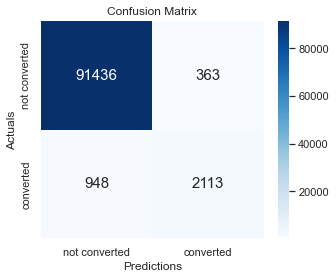

In [243]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(conf_matrix,xticklabels=['not converted','converted'],
            yticklabels=['not converted','converted'],annot=True,
            fmt="g", annot_kws={"size": 15},cmap="Blues",ax=ax)
ax.set_xlabel('Predictions', fontsize=Fontsize)
ax.set_ylabel('Actuals', fontsize=Fontsize)
plt.title('Confusion Matrix', fontsize=Fontsize)
plt.show()

In [244]:
from sklearn.metrics import classification_report
print('Classification report:')
print(classification_report(y_test, y_pred_lr))


f1_macro = f1_score(y_test, y_pred_lr,average='macro')
print(f"The macro F1 socre is {f1_macro}")

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91799
           1       0.85      0.69      0.76      3061

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.88     94860
weighted avg       0.99      0.99      0.99     94860

The macro F1 socre is 0.8780556323579566


### 2.2.3. Feature importance

Here, we want to understand what types of users are mostly likely to convert. We measure the feature importance by the weights provided by the logistic regression model.


From the table and barplot below, we find that **users from Germany are mostly likely to convert, followed by UK and US users. In addition, older users are more likely to convert than new users, and so are users who visit more pages.** 

**Different choices of marketing channel sorces don't seem to affect the user conversion rates.**

In [252]:
feature_names = list(X_train.columns)

feature_coefs = model_lr_opt.coef_[0]
df_features = pd.DataFrame(feature_coefs,columns=['weight'],index=feature_names)
df_features['|weight|'] = abs(feature_coefs)
df_features= df_features.sort_values(by='|weight|',ascending=False)
# df_important_features=df_important_features.rename({'country_int':'country','source_int':'source'})
df_features

,weight,|weight|
country_Germany,3.638957,3.638957
country_UK,3.476922,3.476922
country_US,3.128145,3.128145
new_user,-1.732365,1.732365
total_pages_visited,0.760828,0.760828
source_Direct,-0.208927,0.208927
age,-0.074348,0.074348
source_Seo,-0.069542,0.069542


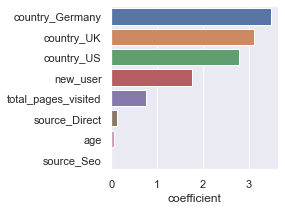

In [191]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_features, y=df_features.index, x="|weight|", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

## 2.3. Random forest 

In [253]:
from sklearn.ensemble import RandomForestClassifier

### 2.3.1. Hyperparameter tuning 
We determine the optimal number of estimators and maximum tree depth for the random forest using cross-validated grid search. To take data imbalance in consideration, we use the macro F1 score. 

The optimal parameters are found to be:
- number of estimators = L2 
- maximum depth = 1000

In [254]:
from sklearn.model_selection import GridSearchCV

t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='f1_macro',return_train_score=True)
model.fit(X_train,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 552.0896298885345 seconds.


In [255]:
best_params_rf = model.best_params_
print(best_params_rf)

{'max_depth': 10, 'n_estimators': 50}


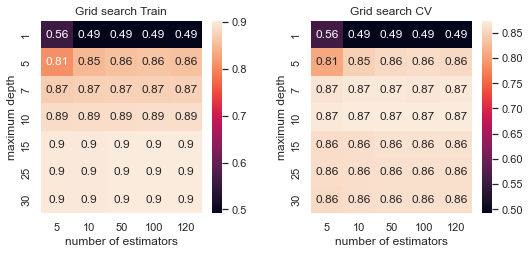

In [256]:
train_f1 = model.cv_results_['mean_train_score'].reshape(7,5)
cv_f1 = model.cv_results_['mean_test_score'].reshape(7,5)


fig, axes = plt.subplots(1,2,figsize= (8,4))
plt.tight_layout(pad=3)
titles = [train_f1,cv_f1]
for i in range(2):
    sns.heatmap(titles[i],xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")
plt.show()

### 2.3.2. Random forest with optimal parameters
Now we train our model with the optimal parameters. The macro F1 score for the predictions is 0.87. 

In [260]:
model_rf_opt = RandomForestClassifier(**best_params_rf)
model_rf_opt.fit(X_train,y_train)
y_pred_rf = model.predict(X_test)

In [262]:
from sklearn.metrics import f1_score
f1_weighted = f1_score(y_test, y_pred_rf, average='macro')
print(f"The weighted F1 score is {f1_weighted}.\n")

The weighted F1 score is 0.8731894003336059.



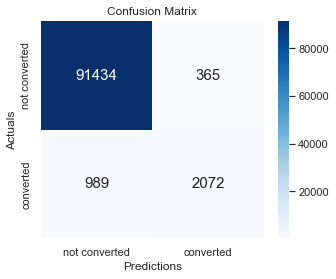

In [258]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(conf_matrix,xticklabels=['not converted','converted'],
            yticklabels=['not converted','converted'],annot=True,
            fmt="g", annot_kws={"size": 15},cmap="Blues",ax=ax)
ax.set_xlabel('Predictions', fontsize=Fontsize)
ax.set_ylabel('Actuals', fontsize=Fontsize)
plt.title('Confusion Matrix', fontsize=Fontsize)
plt.show()

In [263]:
from sklearn.metrics import classification_report
print('Classification report:')
print(classification_report(y_test, y_pred_rf))


f1_macro = f1_score(y_test, y_pred_rf,average='macro')
print(f"The macro F1 socre is {f1_macro}")

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91799
           1       0.85      0.68      0.75      3061

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.87     94860
weighted avg       0.98      0.99      0.98     94860

The macro F1 socre is 0.8731894003336059


### 2.3.3. Feature importance
We would like to know how much each featrue contributes to user conversions. 


From the data frame and barplot below, we see that **the most important feature to user conversions is the total number of pages users have visited** by a large margin, which is logical since the nubmer of pages a user visits should be proportional to their interest in the site and its products. The second important feature is weather the user is new or returning. **Returning users are more likely to make purchases** so the marketing team should prioritize existing users with accounts. 


**The least important feature is the marketing channel source.** 



In [268]:
feature_importance

array([0.04937548, 0.04020408, 0.87677605, 0.00683349, 0.01144678,
       0.01101142, 0.00214899, 0.0022037 ])

In [264]:
feature_importance = model_rf_opt.feature_importances_
df_features = pd.DataFrame(feature_importance,columns=['importance'],index=feature_names)
df_important_features= df_features.sort_values(by='importance',ascending=False)
df_important_features=df_important_features.rename({'country_int':'country','source_int':'source'})
df_important_features

,importance
total_pages_visited,0.876776
age,0.049375
new_user,0.040204
country_UK,0.011447
country_US,0.011011
country_Germany,0.006833
source_Seo,0.002204
source_Direct,0.002149


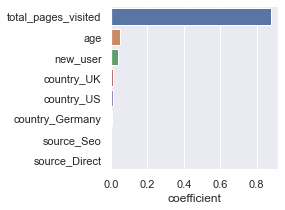

In [266]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_important_features, y=df_important_features.index, x="importance", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

## 2.6. Conclusions and recommendations

**Conclusions:**

The feature importance calculation verify our speculations that the **a higher total number of pages a user has visited has a positive effect on the user conversion rate while marketing channeling sources have litte effect on the conversion rate**. 

We gained the additional information that **the importance of total number of pages visited outweights other user features by a large margin. This tells us the marketing team should highly target users who have visited more pages, as they are most likely to make purchases.**

Also, **younger users with existing accounts and from countries with high conversion rates should also be prioritized. Different choices of marketing channeling sources has little impact on the user conversion rate and should be considered irrelavent.**  

**Recommendations:**
1. The marketing team should highly prioritize users who have visited many pages but haven't made a purchase, e.g., sending them email advertisements/coupons.  
2. Younger users have higher conversion rates than old users. The marketing team should **expand their marketing channels to increases product/brand exposure to younger populaiton, e.g., advertisements on social platforms popular among young people**. Also, **investigate why the site is unpopular among older users, e.g., conduct surveys to identify the problems**. It could the that the UI is unfriendly, or the digital payment system is hard to navigate, etc. 
3. German users have the highest conversion rates but only 4.1% of the total users are German. The marketing team should **expand market channels in Germany to bring in more German users**; on the other hand Chinese users have extremely low conversion rate. Considering that around 1/4 of the users are from China, the low conversion rate doesn't make much sense. **There could critical issues with the Chinese site's UI (e.g., poor translation ), payment system, brand reputation, etc. If the issues are identified and fixed, this could be a massive opportunity seeing how large the Chinese market is**. 
4. Users with existing accounts have higher conversion rates compared to new users. Thus **users with accounts but have not converted could be targeted with advertising**. 



